In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install imutils
import numpy as np 
import pandas as pd 
import random
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline
import imutils    
from google.colab.patches import cv2_imshow
import argparse
import cv2
import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
def load_data(folder, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for filename in os.listdir(folder):
        new_dir = folder +"/"+filename
        for img in os.listdir(new_dir):
          image = cv2.imread(new_dir+'/'+img)
          image = cv2.resize(image, dsize=(image_width, image_height))
          hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
          
          hsv = hsv/127.5-1
          X.append(hsv)
          if new_dir[-3:] == 'yes':
            y.append([1])
          else:
            y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    # print(X_train[1:])
    
    return X, y

In [4]:
IMG_WIDTH, IMG_HEIGHT = (64, 64)

X, y = load_data('/content/drive/MyDrive/mini projectdataset/brain_tumor_dataset', (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 253
X shape is: (253, 64, 64, 3)
y shape is: (253, 1)


In [17]:
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

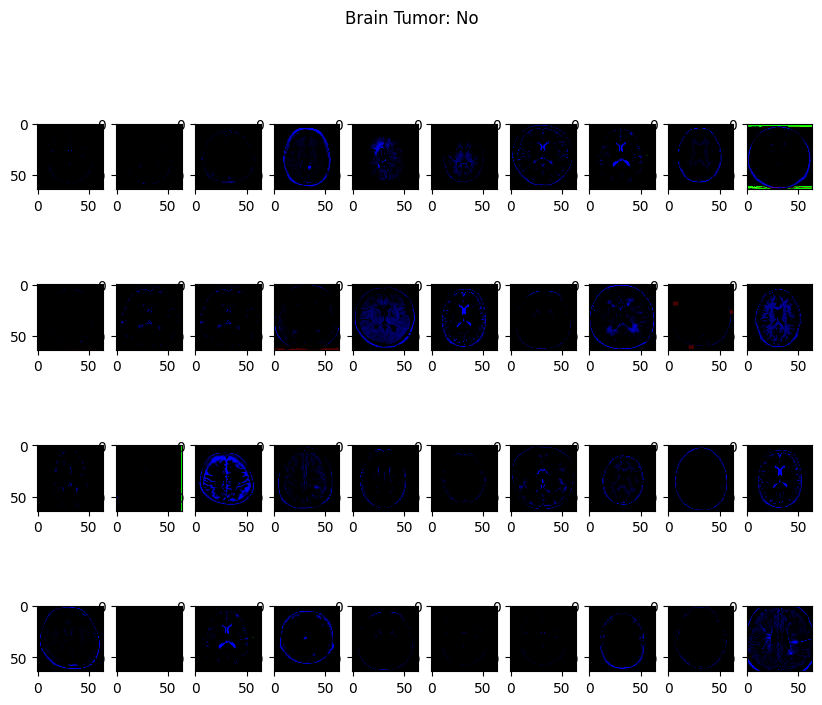

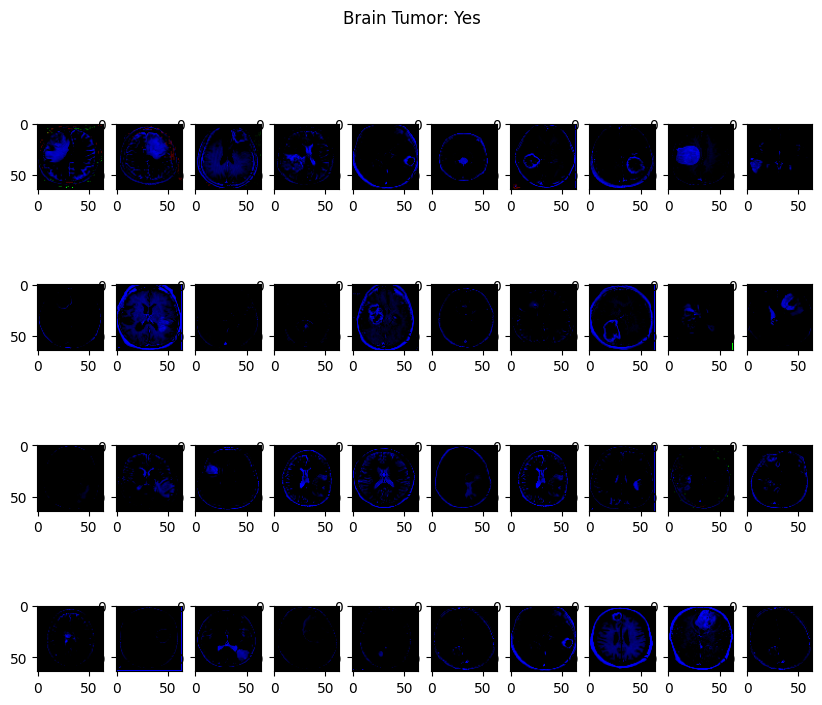

In [18]:
plot_sample_images(X, y)

In [7]:
def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.2)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.2)

# Model Generation

In [9]:
# Create a model
model = Sequential()

# First Layer
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu',input_shape=(64,64,3)))

# Second Layer
model.add(MaxPooling2D(pool_size=(2,2)))

# Third Layer
model.add(Flatten())    # Flatten feature arrays

# Fourth Layer
model.add(Dense(128, activation='relu'))  # Add hidden dense layer

# Fifth Layer
model.add(Dense(1, activation='sigmoid'))   # Add output layer

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 30752)             0         
                                                                 
 dense (Dense)               (None, 128)               3936384   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3,937,409
Trainable params: 3,937,409
Non-trainable params: 0
______________________________________________

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=40, validation_data=(X_val, y_val))

Epoch 1/40
7/7 [==============================] - 13s 53ms/step - loss: 1.9340 - accuracy: 0.5099 - val_loss: 1.2975 - val_accuracy: 0.4545
Epoch 2/40
7/7 [==============================] - 0s 9ms/step - loss: 0.9120 - accuracy: 0.6535 - val_loss: 0.5459 - val_accuracy: 0.8182
Epoch 3/40
7/7 [==============================] - 0s 17ms/step - loss: 0.5421 - accuracy: 0.7228 - val_loss: 0.5920 - val_accuracy: 0.6364
Epoch 4/40
7/7 [==============================] - 0s 14ms/step - loss: 0.4121 - accuracy: 0.8218 - val_loss: 0.4658 - val_accuracy: 0.7273
Epoch 5/40
7/7 [==============================] - 0s 14ms/step - loss: 0.3739 - accuracy: 0.8416 - val_loss: 0.4797 - val_accuracy: 0.8182
Epoch 6/40
7/7 [==============================] - 0s 14ms/step - loss: 0.3196 - accuracy: 0.8663 - val_loss: 0.4421 - val_accuracy: 0.7273
Epoch 7/40
7/7 [==============================] - 0s 15ms/step - loss: 0.2672 - accuracy: 0.8861 - val_loss: 0.4555 - val_accuracy: 0.8182
Epoch 8/40
7/7 [===========

In [13]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

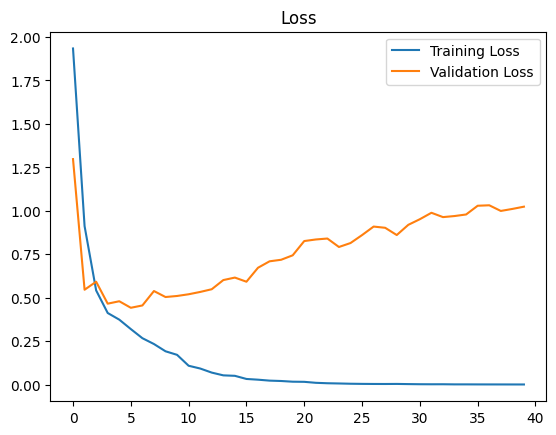

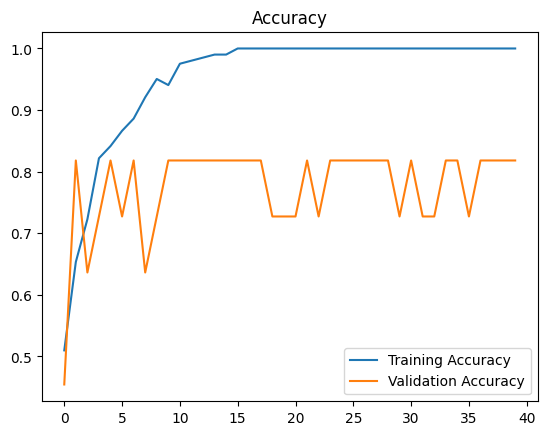

In [14]:
history = model.history.history
plot_metrics(history)

In [15]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 36ms/step - loss: 1.0918 - accuracy: 0.7500


[1.091757893562317, 0.75]

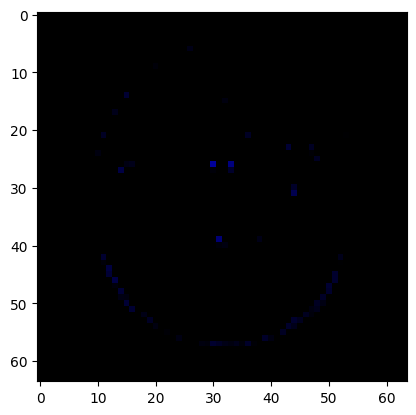

1/1 [==============================] - 0s 111ms/step
[[False]]
Our model says it is a : Tumour


In [16]:
idx2=random.randint(0,40)
plt.imshow(X_test[idx2,:])
plt.show()
y_pred = model.predict(X_test[idx2, :].reshape(1, 64, 64, 3))
y_pred = y_pred > 0.5
print(y_pred)
if(y_pred < 0.5):
    pred = 'Tumour'
else:
    pred = 'No tumour'
    
print("Our model says it is a :", pred)